# Inference pipeline

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
#export 
from xview2comp.nb_03 import *

### Pre-disaster and post-disaster image file paths

In [3]:
SOURCE = Path('data/test/images')
SOURCE.ls()[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_post_00171.png'),
 PosixPath('data/test/images/test_pre_00064.png')]

In [4]:
preimgs = pre_img_fpaths(get_image_files(SOURCE))

In [5]:
posimgs = [pre2post_fpath(o) for o in preimgs]

In [6]:
len(preimgs), len(posimgs)

(933, 933)

In [7]:
preimgs[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_pre_00064.png'),
 PosixPath('data/test/images/test_pre_00091.png')]

In [8]:
posimgs[:3]

[PosixPath('data/test/images/test_post_00831.png'),
 PosixPath('data/test/images/test_post_00064.png'),
 PosixPath('data/test/images/test_post_00091.png')]

### Building detection

In [45]:
#seglearn = load_learner('./', file='building_detector.pkl', test=SegItemListCustom(preimgs), tfm_y=False)
seglearn = load_learner('./', file='building_detector.pkl')

In [46]:
#y_mask, pred_mask, raw_pred_mask = seglearn.get_preds(ds_type=DatasetType.Test)

In [121]:
idx = 117

#idx = 67 #all undamaged  
#idx = 34 #no features

In [122]:
img = open_image(preimgs[idx])
print(preimgs[idx])

data/test/images/test_pre_00290.png


In [123]:
%%time
y_mask, pred_mask, raw_pred_mask = seglearn.predict(img)

CPU times: user 688 ms, sys: 36 ms, total: 724 ms
Wall time: 364 ms


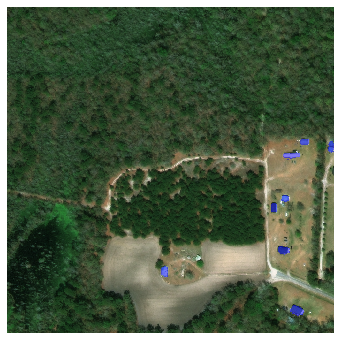

In [124]:
_, ax = plt.subplots(figsize=(6, 6))
img.show(ax)
y_mask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Building mask -> polygons

In [125]:
_, polys = bmask2polys(y_mask.data[0].numpy())

In [126]:
type(polys), len(polys)

(numpy.ndarray, 12)

### Generate unique ids for polygons

In [127]:
#export
def generate_uid_polys(polys): return np.array([str(uuid4()) for _ in polys])

In [128]:
uids = generate_uid_polys(polys)

### Get polygon images

In [129]:
path = Path('tmp_polyimgs')

In [130]:
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True)

In [131]:
img = open_image(posimgs[idx])

In [132]:
for uid, p in zip(uids, polys):
    polyimg = crop_by_polygon(img, p)
    polyimg.save(path/f'{uid}.png')

Refactor into function.

In [133]:
#export
def polyimgs2disk(img, polys, path=None):
    if path is None: path = Path('tmp_polyimgs')
    shutil.rmtree(path, ignore_errors=True); os.makedirs(path, exist_ok=True)
    if len(polys) == 0: return path, []
    uids = generate_uid_polys(polys)
    for uid, p in zip(uids, polys): crop_by_polygon(img, p).save(path/f'{uid}.png')
    return path, uids

In [134]:
path, uids = polyimgs2disk(img, polys, path)

In [135]:
len(path.ls()), len(uids)

(12, 12)

### Damage classification

In [136]:
%%time
il = ImageList([path/f'{uid}.png' for uid in uids])
damglearn = load_learner('./', file='damg_sz299_bs32_resnet50_mixup_stage2.pkl', test=il)

CPU times: user 104 ms, sys: 44 ms, total: 148 ms
Wall time: 100 ms


In [137]:
len(il.items)

12

In [138]:
%%time
pred_damg, y_damg = damglearn.get_preds(ds_type=DatasetType.Test)

CPU times: user 72 ms, sys: 276 ms, total: 348 ms
Wall time: 475 ms


In [139]:
pred_classes = [damglearn.data.classes[i] for i in pred_damg.argmax(dim=1)]

In [140]:
pred_classes[3], pred_damg[3], y_damg[3], y_damg.sum()

('major',
 tensor([9.1598e-04, 3.6668e-02, 9.5486e-01, 7.5606e-03]),
 tensor(0),
 tensor(0))

In [141]:
len(pred_classes), len(uids), len(polys), img

(12, 12, 12, Image (3, 1024, 1024))

Refactor into function.

In [142]:
#export
def assess_damage_polyimgs(polyimgs, path='./', file='damg_sz299_bs32_resnet50_mixup_stage2.pkl'):
    if len(polyimgs.items) == 0: return [] # Need `.items` because `len(ImageList)` is 1 for empty list.
    damglearn = load_learner(path, file, test=polyimgs)
    pred_damg, _ = damglearn.get_preds(ds_type=DatasetType.Test)
    return [damglearn.data.classes[o] for o in pred_damg.argmax(dim=1)]

In [143]:
polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
damgs = assess_damage_polyimgs(polyimgs)

In [144]:
damgs[3], len(damgs)

('major', 12)

### Damage mask

In [109]:
CATS

['nun', 'minor', 'major', 'destroyed']

In [110]:
#export
DAMG_OTOI = {'nun':1, 'minor':2, 'major':3, 'destroyed':4}

In [111]:
damgmask = np.zeros(img.shape[1:], dtype=np.uint8)

In [112]:
for damg, poly in zip(damgs, polys):
    cv2.fillPoly(damgmask, poly[None,...], (DAMG_OTOI[damg]))
    
damgmask = ImageSegment(tensor(damgmask[None,...]))

Refactor into function.

In [113]:
#export
def damgpolys2damgmask(polys, damgs, sz=1024):
    assert len(polys) == len(damgs)
    if isinstance(sz, int): sz = (sz, sz)
    mask = np.zeros(sz, dtype=np.uint8)
    if len(polys) > 0:
        for damg, poly in zip(damgs, polys): 
            cv2.fillPoly(mask, poly[None,...], (DAMG_OTOI[damg]))
    return ImageSegment(tensor(mask[None,...]))

In [114]:
damgmask = damgpolys2damgmask(polys, damgs, img.shape[1:])

In [115]:
damgmask.data.unique()

tensor([0, 1, 3])

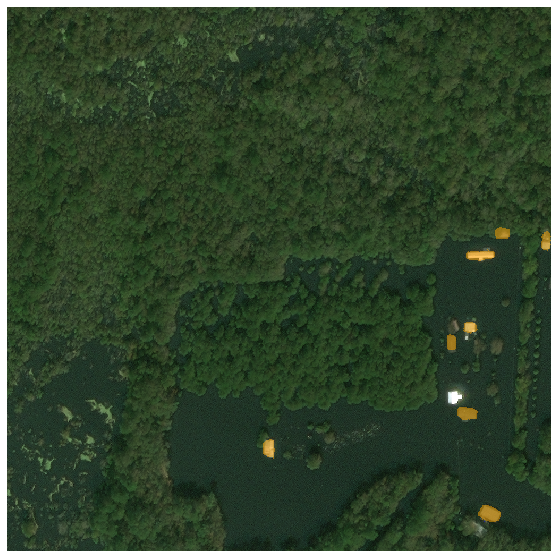

In [116]:
_, ax = plt.subplots(figsize=(10, 10))
img.show(ax)
damgmask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Pipeline

In [88]:
#export
def infer_sample(path_preimg, path_posimg, seglearn, path_damglearn):
    img = open_image(path_preimg)
    y_mask, _, _ = seglearn.predict(img)
    _, polys = bmask2polys(y_mask.data[0].numpy())
    img = open_image(path_posimg)
    path, uids = polyimgs2disk(img, polys, path=Path('tmp_polyimgs'))
    polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
    damgs = assess_damage_polyimgs(polyimgs, file=path_damglearn)
    damgmask = damgpolys2damgmask(polys, damgs, sz=img.shape[1:])
    return damgmask

def get_imgid(imgname): return imgname.stem.split('_')[-1]

In [89]:
path_results = Path('./inference_results')

In [90]:
os.makedirs(path_results, exist_ok=True)

In [91]:
idx = 332
damgmask = infer_sample(preimgs[idx], posimgs[idx], seglearn, 'damg_sz299_bs32_resnet50_mixup_stage2.pkl')

tensor([0, 1, 2, 3, 4])

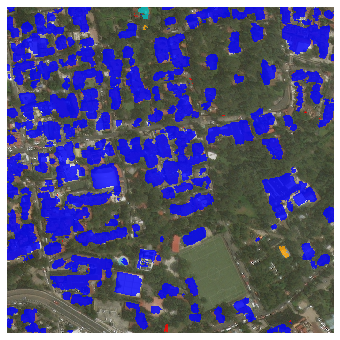

In [92]:
_, ax = plt.subplots(figsize=(6, 6))
open_image(posimgs[idx]).show(ax)
damgmask.show(ax, alpha=.8, cmap=CMAP, vmax=len(CMAP.colors)-1)
damgmask.data.unique()

Takes about 40 minutes to generate the inference .pngs for the entire test set.

In [93]:
for idx in progress_bar(range(len(preimgs))):
    npre, npos = preimgs[idx], posimgs[idx]
    damgmask = infer_sample(npre, npos, seglearn, 'damg_sz299_bs32_resnet50_mixup_stage2.pkl')
    imgid = get_imgid(npre)
    damgmask.save(path_results/f'test_localization_{imgid}_prediction.png')
    damgmask.save(path_results/f'test_damage_{imgid}_prediction.png')

### Load a few saved submission png files

In [94]:
print(len(get_image_files(path_results)))
get_image_files(path_results)[:5]

1866


[PosixPath('inference_results/test_localization_00536_prediction.png'),
 PosixPath('inference_results/test_damage_00313_prediction.png'),
 PosixPath('inference_results/test_damage_00142_prediction.png'),
 PosixPath('inference_results/test_localization_00376_prediction.png'),
 PosixPath('inference_results/test_damage_00919_prediction.png')]

In [147]:
imgid = get_imgid(preimgs[117])
#imgid = get_imgid(preimgs[332]) #Lots of buildings [0, 1, 3, 4]
# imgid = '00064'  no buildings

In [148]:
path_local = path_results/f'test_localization_{imgid}_prediction.png'
path_damg = path_results/f'test_damage_{imgid}_prediction.png'

In [149]:
np.unique(PIL.Image.open(path_damg))

array([0, 1, 3], dtype=uint8)

In [150]:
CMAP.colors

['None', 'b', 'c', 'orange', 'r']

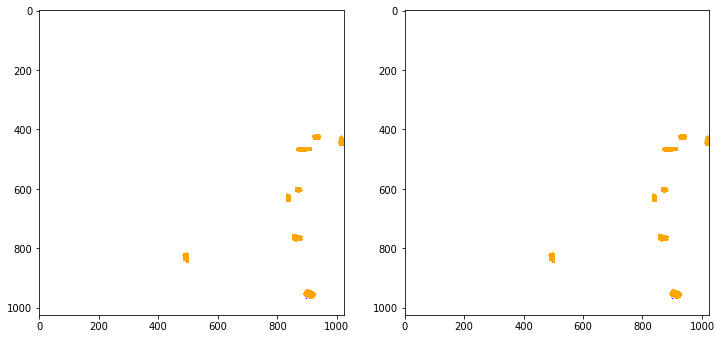

In [151]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 15))
axs[0].imshow(np.array(PIL.Image.open(path_local)), cmap=CMAP, vmin=0, vmax=4)
axs[1].imshow(np.array(PIL.Image.open(path_damg)), cmap=CMAP, vmin=0, vmax=4);

In [100]:
cv2.imread(path_damg, 1)

SystemError: <built-in function imread> returned NULL without setting an error

In [152]:
mask_local, mask_damg = open_mask(path_local), open_mask(path_damg)

In [153]:
mask_local.data.unique(), mask_damg.data.unique()

(tensor([0, 1, 3]), tensor([0, 1, 3]))

In [154]:
CMAP.colors

['None', 'b', 'c', 'orange', 'r']

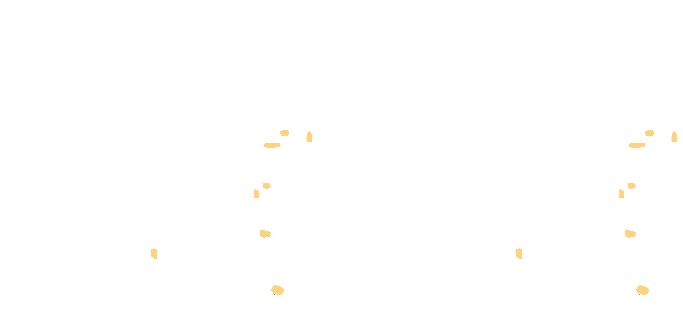

In [155]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6))
open_mask(path_local).show(axs[0], cmap=CMAP, vmax=len(CMAP.colors) - 1)
open_mask(path_damg).show(axs[1], cmap=CMAP, vmax=len(CMAP.colors) - 1)

### Save submission png files into tarball

In [106]:
#! tar czvf inference_results.tar.gz {path_results}

inference_results/
inference_results/test_localization_00536_prediction.png
inference_results/test_damage_00313_prediction.png
inference_results/test_damage_00142_prediction.png
inference_results/test_localization_00376_prediction.png
inference_results/test_damage_00919_prediction.png
inference_results/test_localization_00111_prediction.png
inference_results/test_localization_00065_prediction.png
inference_results/test_damage_00620_prediction.png
inference_results/test_localization_00315_prediction.png
inference_results/test_localization_00206_prediction.png
inference_results/test_localization_00556_prediction.png
inference_results/test_localization_00789_prediction.png
inference_results/test_localization_00435_prediction.png
inference_results/test_localization_00931_prediction.png
inference_results/test_damage_00161_prediction.png
inference_results/test_localization_00506_prediction.png
inference_results/test_localization_00501_prediction.png
inference_results/test_localization_00621_

inference_results/test_damage_00723_prediction.png
inference_results/test_damage_00099_prediction.png
inference_results/test_damage_00079_prediction.png
inference_results/test_localization_00888_prediction.png
inference_results/test_localization_00672_prediction.png
inference_results/test_localization_00765_prediction.png
inference_results/test_damage_00659_prediction.png
inference_results/test_damage_00094_prediction.png
inference_results/test_localization_00357_prediction.png
inference_results/test_damage_00275_prediction.png
inference_results/test_damage_00343_prediction.png
inference_results/test_localization_00616_prediction.png
inference_results/test_localization_00587_prediction.png
inference_results/test_localization_00053_prediction.png
inference_results/test_damage_00325_prediction.png
inference_results/test_localization_00196_prediction.png
inference_results/test_localization_00736_prediction.png
inference_results/test_damage_00390_prediction.png
inference_results/test_local

inference_results/test_localization_00151_prediction.png
inference_results/test_damage_00717_prediction.png
inference_results/test_damage_00874_prediction.png
inference_results/test_damage_00449_prediction.png
inference_results/test_damage_00138_prediction.png
inference_results/test_damage_00364_prediction.png
inference_results/test_damage_00527_prediction.png
inference_results/test_localization_00384_prediction.png
inference_results/test_damage_00425_prediction.png
inference_results/test_damage_00586_prediction.png
inference_results/test_damage_00139_prediction.png
inference_results/test_localization_00221_prediction.png
inference_results/test_damage_00190_prediction.png
inference_results/test_localization_00204_prediction.png
inference_results/test_localization_00544_prediction.png
inference_results/test_localization_00596_prediction.png
inference_results/test_damage_00468_prediction.png
inference_results/test_localization_00679_prediction.png
inference_results/test_damage_00866_pred

inference_results/test_localization_00761_prediction.png
inference_results/test_damage_00262_prediction.png
inference_results/test_localization_00291_prediction.png
inference_results/test_localization_00299_prediction.png
inference_results/test_damage_00450_prediction.png
inference_results/test_damage_00776_prediction.png
inference_results/test_damage_00890_prediction.png
inference_results/test_localization_00932_prediction.png
inference_results/test_localization_00793_prediction.png
inference_results/test_damage_00534_prediction.png
inference_results/test_localization_00683_prediction.png
inference_results/test_damage_00528_prediction.png
inference_results/test_localization_00000_prediction.png
inference_results/test_localization_00502_prediction.png
inference_results/test_localization_00890_prediction.png
inference_results/test_localization_00664_prediction.png
inference_results/test_damage_00066_prediction.png
inference_results/test_localization_00681_prediction.png
inference_result

inference_results/test_damage_00549_prediction.png
inference_results/test_damage_00889_prediction.png
inference_results/test_localization_00727_prediction.png
inference_results/test_localization_00691_prediction.png
inference_results/test_localization_00692_prediction.png
inference_results/test_damage_00341_prediction.png
inference_results/test_damage_00746_prediction.png
inference_results/test_localization_00819_prediction.png
inference_results/test_damage_00193_prediction.png
inference_results/test_localization_00903_prediction.png
inference_results/test_damage_00825_prediction.png
inference_results/test_localization_00122_prediction.png
inference_results/test_damage_00818_prediction.png
inference_results/test_damage_00124_prediction.png
inference_results/test_localization_00389_prediction.png
inference_results/test_damage_00707_prediction.png
inference_results/test_localization_00473_prediction.png
inference_results/test_localization_00629_prediction.png
inference_results/test_damag

inference_results/test_damage_00412_prediction.png
inference_results/test_damage_00436_prediction.png
inference_results/test_damage_00597_prediction.png
inference_results/test_localization_00051_prediction.png
inference_results/test_localization_00702_prediction.png
inference_results/test_localization_00834_prediction.png
inference_results/test_damage_00266_prediction.png
inference_results/test_damage_00820_prediction.png
inference_results/test_localization_00156_prediction.png
inference_results/test_localization_00762_prediction.png
inference_results/test_localization_00408_prediction.png
inference_results/test_localization_00279_prediction.png
inference_results/test_localization_00227_prediction.png
inference_results/test_localization_00322_prediction.png
inference_results/test_damage_00247_prediction.png
inference_results/test_localization_00885_prediction.png
inference_results/test_localization_00816_prediction.png
inference_results/test_localization_00179_prediction.png
inference_

inference_results/test_localization_00870_prediction.png
inference_results/test_damage_00865_prediction.png
inference_results/test_damage_00065_prediction.png
inference_results/test_damage_00813_prediction.png
inference_results/test_damage_00270_prediction.png
inference_results/test_localization_00061_prediction.png
inference_results/test_damage_00372_prediction.png
inference_results/test_localization_00220_prediction.png
inference_results/test_localization_00296_prediction.png
inference_results/test_damage_00001_prediction.png
inference_results/test_localization_00646_prediction.png
inference_results/test_damage_00225_prediction.png
inference_results/test_localization_00390_prediction.png
inference_results/test_localization_00067_prediction.png
inference_results/test_localization_00178_prediction.png
inference_results/test_damage_00622_prediction.png
inference_results/test_damage_00523_prediction.png
inference_results/test_damage_00667_prediction.png
inference_results/test_localizatio

inference_results/test_localization_00599_prediction.png
inference_results/test_damage_00497_prediction.png
inference_results/test_damage_00571_prediction.png
inference_results/test_localization_00002_prediction.png
inference_results/test_damage_00132_prediction.png
inference_results/test_damage_00796_prediction.png
inference_results/test_localization_00476_prediction.png
inference_results/test_damage_00664_prediction.png
inference_results/test_localization_00286_prediction.png
inference_results/test_damage_00074_prediction.png
inference_results/test_localization_00602_prediction.png
inference_results/test_damage_00925_prediction.png
inference_results/test_localization_00811_prediction.png
inference_results/test_damage_00465_prediction.png
inference_results/test_damage_00335_prediction.png
inference_results/test_damage_00149_prediction.png
inference_results/test_localization_00194_prediction.png
inference_results/test_localization_00705_prediction.png
inference_results/test_damage_0003

inference_results/test_localization_00498_prediction.png
inference_results/test_localization_00628_prediction.png
inference_results/test_damage_00905_prediction.png
inference_results/test_damage_00760_prediction.png
inference_results/test_localization_00236_prediction.png
inference_results/test_localization_00260_prediction.png
inference_results/test_localization_00250_prediction.png
inference_results/test_damage_00098_prediction.png
inference_results/test_damage_00759_prediction.png
inference_results/test_damage_00075_prediction.png
inference_results/test_localization_00682_prediction.png
inference_results/test_damage_00515_prediction.png
inference_results/test_damage_00819_prediction.png
inference_results/test_damage_00697_prediction.png
inference_results/test_localization_00330_prediction.png
inference_results/test_localization_00586_prediction.png
inference_results/test_damage_00209_prediction.png
inference_results/test_damage_00887_prediction.png
inference_results/test_damage_0091

inference_results/test_damage_00004_prediction.png
inference_results/test_damage_00545_prediction.png
inference_results/test_localization_00148_prediction.png
inference_results/test_localization_00235_prediction.png
inference_results/test_localization_00012_prediction.png
inference_results/test_localization_00391_prediction.png
inference_results/test_damage_00382_prediction.png
inference_results/test_damage_00204_prediction.png
inference_results/test_damage_00395_prediction.png
inference_results/test_damage_00264_prediction.png
inference_results/test_damage_00910_prediction.png
inference_results/test_damage_00764_prediction.png
inference_results/test_localization_00889_prediction.png
inference_results/test_localization_00591_prediction.png
inference_results/test_damage_00654_prediction.png
inference_results/test_localization_00554_prediction.png
inference_results/test_damage_00651_prediction.png
inference_results/test_damage_00583_prediction.png
inference_results/test_damage_00878_pred

In [107]:
! du -hs inference_results*

18M	inference_results
12M	inference_results.tar.gz


# - fin

In [145]:
! python notebook2script.py 03b_inference_pipeline.ipynb

Converted 03b_inference_pipeline.ipynb to xview2comp/nb_03b.py
